<a href="https://colab.research.google.com/github/JYKnomad/JYKnomad/blob/main/20220317_ver5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip install pydicom

## IMPORT THE MODULES

# DATA PREPROCESSING
from glob import glob
import numpy as np
import pydicom, cv2, os
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import matplotlib.pyplot as plt
from PIL import Image

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import adam_v2

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

## CONFIGURE THE VARIABLES
### 경로 설정 - 데이터와 레이블을 불러올 경로를 설정

root = '/content/drive/MyDrive/segmentation/data/'
idx_path = 'seg_006/'
data_path = ['dicom/','image/','mask/','mask_slicer/','mask_test/','prediction/']

### 훈련 디렉토리와 빈 디렉토리를 저장할 리스트

logger = []
nor_path = []

## CREATE THE PATHS LISTS

### 
for pt_no in range(1,17):
    pt_idx = 'seg_%03d/'%pt_no
    for sr_no in range(1,3):
        idx = 'seg_%03d_%d/'%(pt_no,sr_no)
        path = root + pt_idx + idx
        if os.path.exists(path):
            if len(os.listdir(path+'dicom/')) == 0:
                logger.append(path)
            else:
                nor_path.append(path)
        else:
            logger.append(path)
            pass

## CONFIRM THE PATHS

print('Number of vacant folder :', len(logger))
for i, elem in enumerate(logger):
    print('%02d'%(i+1),'  ' ,elem)
    
print(len(nor_path))
for i, elem in enumerate(nor_path):
    print('%02d'%(i+1),'  ' ,elem)
    
nor_path = nor_path[:4]

nor_path


train_imgs_path = []
train_msks_path = []
for elem_path in nor_path:
    temp_train_imgs_path = sorted(glob(elem_path+'dicom/*.dcm'))
    for elem in temp_train_imgs_path:
        train_imgs_path.append(elem)
for elem_path in nor_path:
    temp_train_msks_path = sorted(glob(elem_path+'mask_test/*.png'))
    for elem in temp_train_msks_path:
        train_msks_path.append(elem)
print('Image numbers: ', len(train_imgs_path))
print('Masks numbers: ', len(train_msks_path))


     |████████████████████████████████| 2.0 MB 5.3 MB/s 
Number of vacant folder : 17
01    /content/drive/MyDrive/segmentation/data/seg_004/seg_004_2/
02    /content/drive/MyDrive/segmentation/data/seg_007/seg_007_2/
03    /content/drive/MyDrive/segmentation/data/seg_008/seg_008_1/
04    /content/drive/MyDrive/segmentation/data/seg_008/seg_008_2/
05    /content/drive/MyDrive/segmentation/data/seg_009/seg_009_1/
06    /content/drive/MyDrive/segmentation/data/seg_009/seg_009_2/
07    /content/drive/MyDrive/segmentation/data/seg_010/seg_010_2/
08    /content/drive/MyDrive/segmentation/data/seg_011/seg_011_1/
09    /content/drive/MyDrive/segmentation/data/seg_011/seg_011_2/
10    /content/drive/MyDrive/segmentation/data/seg_012/seg_012_1/
11    /content/drive/MyDrive/segmentation/data/seg_012/seg_012_2/
12    /content/drive/MyDrive/segmentation/data/seg_013/seg_013_1/
13    /content/drive/MyDrive/segmentation/data/seg_013/seg_013_2/
14    /content/drive/MyDrive/segmentation/data/seg_015/s

In [3]:

!nvidia-smi

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))


Thu Mar 17 07:57:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

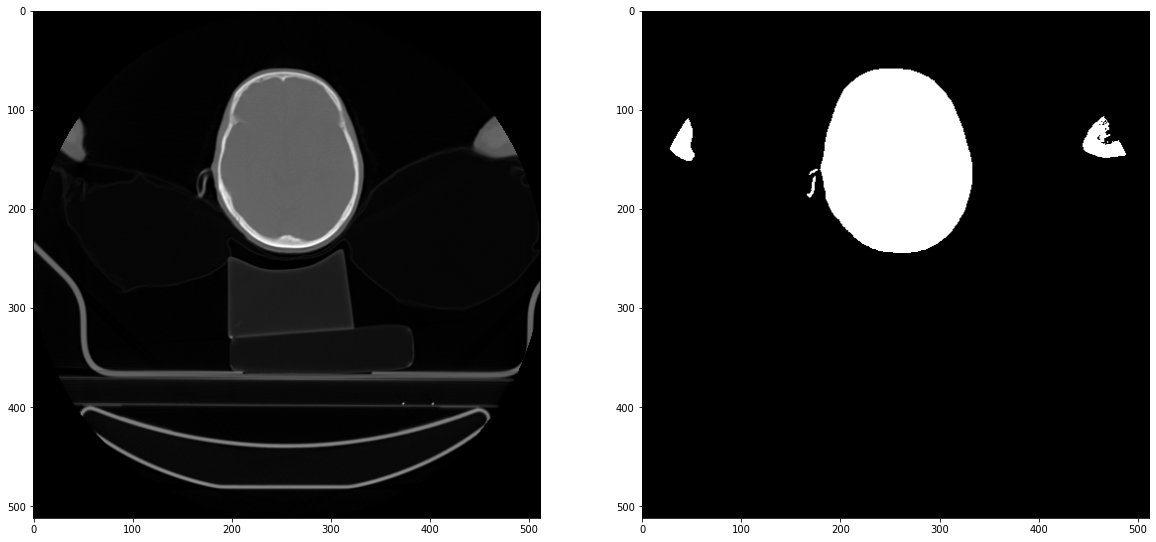

In [4]:

## CREATE THE TRAIN DATA AND LABELS

train_imgs = []
for path in train_imgs_path:
    obj = pydicom.dcmread(path)
    arr = obj.pixel_array
    Max_val = np.max(arr)
    Min_val = np.min(arr)
    Up_arr = arr - Min_val
    Dn_arr = Max_val - Min_val
    nor_arr = Up_arr / Dn_arr
    train_imgs.append(nor_arr)
train_imgs = np.array(train_imgs)
train_msks = []
for path in train_msks_path:
    temp_obj = Image.open(path)
    temp_arr = np.array(temp_obj)
    train_msks.append(temp_arr)
train_msks = np.array(train_msks)


train_msks = train_msks.astype(np.float32)
train_msks = np.reshape(train_msks, (*train_msks.shape, 1))


train_msks -= 1


# import numpy as np

# a = np.load('/content/drive/MyDrive/segmentation/data/train_imgs_comp.npz')
# b = np.load('/content/drive/MyDrive/segmentation/data/train_msks_comp.npz')

# a.files
# train_imgs = a['train_imgs']
# b.files
# train_msks = b['a']


## CONFIRM THE TRAIN DATA ND LABELS


%matplotlib inline

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[700], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[700]), cmap='gray')

# TENSORFLOW

## CONSTRUCT THE MODEL (U_NET)

In [5]:

inputs = Input((512, 512, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])


## CUSTOM OBJECTS

SMOOTH = 1.

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


## COMPILE

model.compile(adam_v2.Adam(learning_rate=1e-4), bce_dice_loss, metrics=[binary_crossentropy, dice_coef])


## TRAIN(FIT)

model.fit(train_imgs[:1000], train_msks[:1000], batch_size=12, epochs=10, validation_data=(train_imgs[1000:], train_msks[1000:]))

## SAVE THE TRAINED MODEL

model.save('my_model.h5')

## LOAD THE SAVED MODEL

new_model = tf.keras.models.load_model('/content/drive/MyDrive/segmentation/data/my_model.h5',custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef': dice_coef} )



Epoch 1/10
84/84 [==============================] - 228s 2s/step - loss: -0.4889 - binary_crossentropy: 0.3335 - dice_coef: 0.6577 - val_loss: -0.7174 - val_binary_crossentropy: 0.0962 - val_dice_coef: 0.7660
Epoch 2/10
84/84 [==============================] - 191s 2s/step - loss: -0.9302 - binary_crossentropy: 0.0473 - dice_coef: 0.9539 - val_loss: -0.8506 - val_binary_crossentropy: 0.0485 - val_dice_coef: 0.8751
Epoch 3/10
84/84 [==============================] - 191s 2s/step - loss: -0.9618 - binary_crossentropy: 0.0220 - dice_coef: 0.9728 - val_loss: -0.9399 - val_binary_crossentropy: 0.0198 - val_dice_coef: 0.9493
Epoch 4/10
84/84 [==============================] - 191s 2s/step - loss: -0.9742 - binary_crossentropy: 0.0156 - dice_coef: 0.9820 - val_loss: -0.9723 - val_binary_crossentropy: 0.0116 - val_dice_coef: 0.9776
Epoch 5/10
84/84 [==============================] - 192s 2s/step - loss: -0.9846 - binary_crossentropy: 0.0092 - dice_coef: 0.9892 - val_loss: -0.9823 - val_binary_

OSError: ignored

In [ ]:

file_list = sorted(glob(root+idx_path+data_path[1]+'*.jpg'))
predic = []

for elem in file_list:
    img_obj = cv2.imread(elem, cv2.IMREAD_UNCHANGED)
    predic.append(img_obj)

prediction = np.array(predic)


pred_imgs = []

def normalize_conf(input_arr):
    Max_val = np.max(input_arr)
    Min_val = np.min(input_arr)
    Up_arr = input_arr - Min_val
    Dn_arr = Max_val - Min_val
    normal_arr = Up_arr / Dn_arr
    return normal_arr

for i in range(1, 357):
    temp_pred = pydicom.dcmread('/content/drive/MyDrive/segmentation/data/seg_005/seg_005_1/dicom/seg_005_1_dcm_%03d.dcm'%i)
    temp_arry = temp_pred.pixel_array
    temp_norm = normalize_conf(temp_arry)
    pred_imgs.append(temp_norm)

pred_imgs = np.array(pred_imgs)

predictions = np.expand_dims(pred_imgs, axis=3)

## PREDICT

pred_img = model.predict(predictions)

plt_imgs = np.squeeze(pred_img)

for elem in plt_imgs:
    plt.imshow(elem, cmap='gray')
    plt.show()

for i in range(100):
    fig = plt.figure(0, figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(pred_imgs[i], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(np.squeeze(plt_imgs[i]), cmap='gray')
    plt.show()
    
plt_img = np.squeeze(pred_img[0])


plt_img[plt_img < 0.5] = 0

plt_img[plt_img >= 0.5] = 1


plt.imshow(plt_img, cmap='gray')


for i, img in enumerate(temp_pred):
    path_ = '/content/drive/MyDrive/segmentation/data/seg_006/mask/mask_1-%03d.png'%(i+1)
    img = img * 255
    cv2.imwrite(path_, img)
    plt.imshow(img)
    plt.show()
    
temp_2_pred = []

for elem in temp_pred:
    elem[elem<0.5] = 0
    elem[elem>=0.5] = 1
    elem.astype('uint8')
    temp_2_pred.append(elem)


# PREDICT BY THE LOADED MODEL

### 주의: 모듈을 먼저 임포트 하시오.


SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


new_model = tf.keras.models.load_model('/content/drive/MyDrive/segmentation/my_model.h5',custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef': dice_coef} )


pred_imgs = []

def normalize_conf(input_arr):
    Max_val = np.max(input_arr)
    Min_val = np.min(input_arr)
    Up_arr = input_arr - Min_val
    Dn_arr = Max_val - Min_val
    normal_arr = Up_arr / Dn_arr
    return normal_arr

for i in range(1, 357):
    temp_pred = pydicom.dcmread('/content/drive/MyDrive/segmentation/data/seg_005/seg_005_1/dicom/seg_005_1_dcm_%03d.dcm'%i)
    temp_arry = temp_pred.pixel_array
    temp_norm = normalize_conf(temp_arry)
    pred_imgs.append(temp_norm)

pred_imgs = np.array(pred_imgs)

predictions = np.expand_dims(pred_imgs, axis=3)


pred_img = new_model.predict(predictions)

plt_imgs = np.squeeze(pred_img)

for elem in plt_imgs:
    plt.imshow(elem, cmap='gray')
    plt.show()
    
plt_imgs[plt_imgs < 0.5] = 0
plt_imgs[plt_imgs >= 0.5] = 1

plt_imgs = np.array(plt_imgs, dtype='uint8')


for i in range(100):
    fig = plt.figure(0, figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(pred_imgs[i], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(np.squeeze(plt_imgs[i]), cmap='gray')
    plt.show()
    
### TO DO LIST

np.unique(plt_imgs)